In [205]:
import torch
import gpytorch
import numpy as np
import optuna
from src.plotting import plot_gp, plot_train_test_split

from src.data_loader import PVDataLoader
from src import data_loader as dl
from src.models import ApproximateGPBaseModel
from src.hyperparameter_tuning import HyperParameterOptimization
from src.beta_likelihood import BetaLikelihood_MeanParametrization

In [312]:
# set seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# data parameters
DAY_INIT = 0
DAY_MIN = 8
DAY_MAX = 16
N_DAYS = 5
MINUTE_INTERVAL = 5
DAILY_DATA_POINTS = (DAY_MAX - DAY_MIN) * 60 / MINUTE_INTERVAL
N_HOURS_PRED = 3
N_SYSTEMS = 15
RADIUS = 0.35
COORDS = (55, -1.5)
IDX = 6

==> Loading data
==> Loaded data in: 0 m : 9 sec

==> Loading data
==> Loaded data in: 0 m : 0 sec



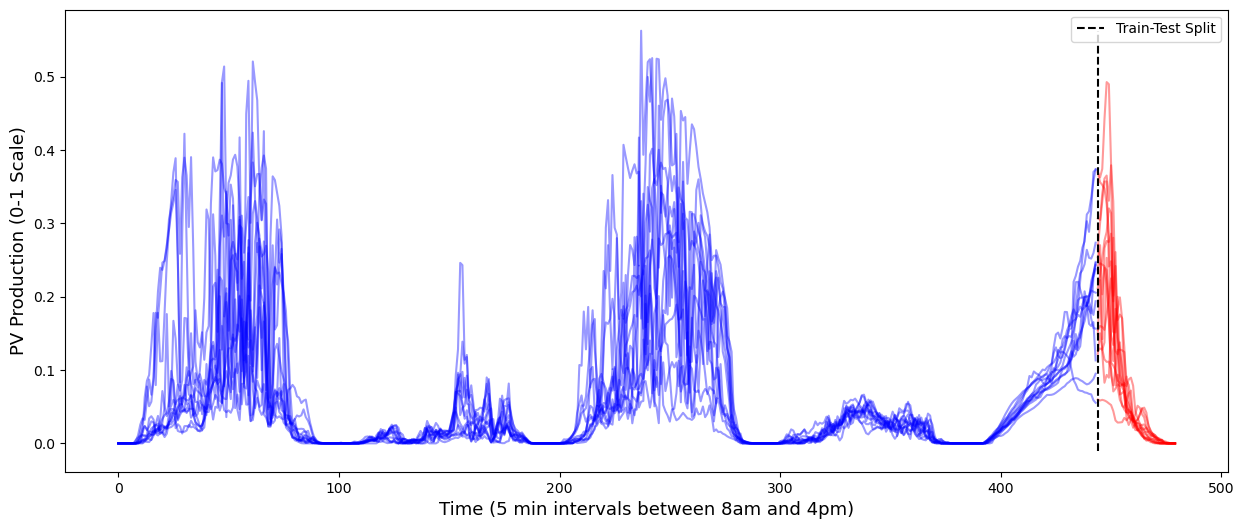

In [313]:
loader = PVDataLoader(n_days=N_DAYS,
                    day_init=DAY_INIT,
                    n_systems=N_SYSTEMS,
                    radius=RADIUS,
                    coords=COORDS,
                    minute_interval=MINUTE_INTERVAL,
                    day_min=DAY_MIN,
                    day_max=DAY_MAX,
                    folder_name='pv_data',
                    file_name_pv='pv_data_clean.csv',
                    file_name_location='location_data_clean.csv')

time, y = loader.get_time_series()
x_train, y_train, x_test, y_test = dl.train_test_split(time, y, n_hours=N_HOURS_PRED)
plot_train_test_split(y_train, y_test)

In [316]:
# get individual time series
y_in = y

if y_in.max() > 1:
    y_in[y_in > 1] = 1
# get time related variables
periodic_time = dl.periodic_mapping(time, DAY_MIN, DAY_MAX, MINUTE_INTERVAL)
x = torch.stack([time, periodic_time], dim=1)

# standardize time dimension of x
x[:, 0] = (x[:, 0] - x[:, 0].mean()) / x[:, 0].std()

# split into train and test
x_train, y_train, x_test, y_test = dl.train_test_split(x, y_in, n_hours=N_HOURS_PRED)

# use all data as inducing points
x_inducing = x_train
y_inducing = y_train

# Stochastic Variational Inference for Gaussian Processes

Limitations:
- stochastic updates which can cause optimization problems and no guarantee of the global optimum is guaranteed, careful initialization and tuning of hyperparameters.
- not exact training data but inducing points (hyperparameter choice)
- not closed form solution for posterior s.t. solution is not exact


Strengths:
- non-gaussian likelihood for flexibility
- scalability
- uncertainty estimation
- approximate inference can capture important aspects of the underlying disitribtuions (giving fairly accurate predictions)

# Kernels

In [317]:
from gpytorch.kernels import (MaternKernel, 
                              PeriodicKernel,
                              RBFKernel,
                              ScaleKernel, 
                              AdditiveKernel, 
                              ProductKernel)
# TODO add a prior to the period in periodic

matern_base = MaternKernel(nu=3/2, 
                      ard_num_dims=x.shape[1], 
                      lengthscale_prior=gpytorch.priors.GammaPrior(2, 8),
                      lengthscale_constraint=gpytorch.constraints.Positive()
                      )
periodic = PeriodicKernel(period_length_prior=gpytorch.priors.GammaPrior(3, 2),
                            period_length_constraint=gpytorch.constraints.Positive()
                        )
scaled_periodic = ScaleKernel(periodic,
                                outputscale_prior=gpytorch.priors.GammaPrior(5, 1),
                                outputscale_constraint=gpytorch.constraints.Positive()
                            )
scaled_matern = ScaleKernel(matern_base, 
                            outputscale_prior=gpytorch.priors.GammaPrior(5, 2),
                            outputscale_constraint=gpytorch.constraints.Interval(0.1, 1)
                            )
product_kernel_matern_periodic = ScaleKernel(periodic * matern_base,
                             outputscale_prior = gpytorch.priors.GammaPrior(5, 2),
                             outputscale_constraint=gpytorch.constraints.Positive()
                            )
rbf_kernel = ScaleKernel(RBFKernel())
product_kernel_rbf_matern = ScaleKernel(rbf_kernel * scaled_matern)


quasi_periodic_rbf = AdditiveKernel(product_kernel_rbf_matern, scaled_matern)
quasi_periodic_matern = AdditiveKernel(product_kernel_matern_periodic, scaled_matern)


Iter 30/300 - Loss: -1.072
Iter 60/300 - Loss: -1.894
Iter 90/300 - Loss: -2.325
Iter 120/300 - Loss: -2.580
Iter 150/300 - Loss: -2.725
Iter 180/300 - Loss: -2.807
Iter 210/300 - Loss: -2.855
Iter 240/300 - Loss: -2.885
Iter 270/300 - Loss: -2.905
Iter 300/300 - Loss: -2.920


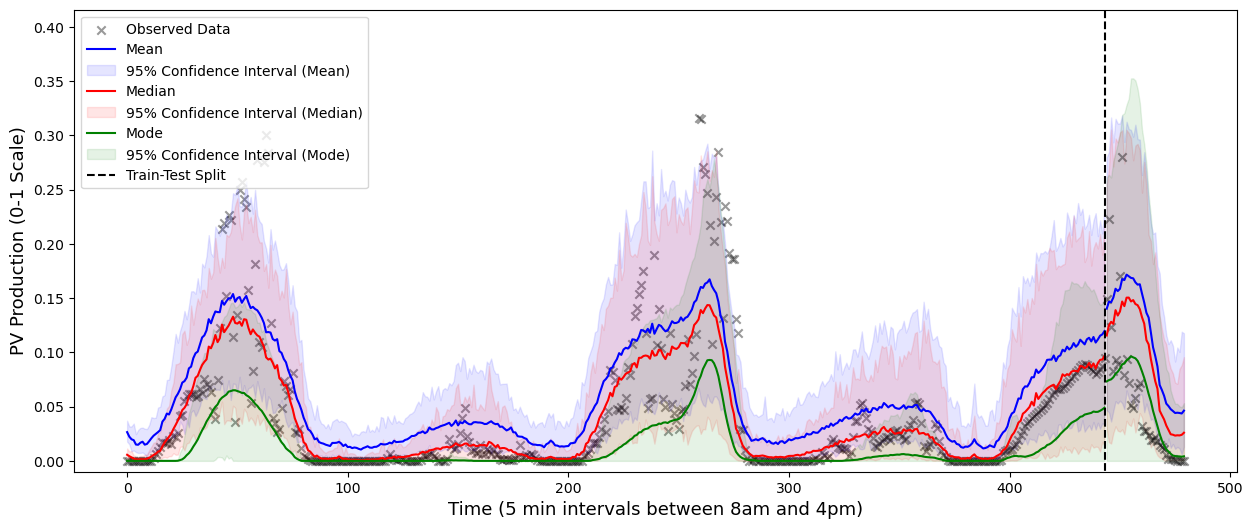

Iter 30/300 - Loss: -0.678
Iter 60/300 - Loss: -1.767
Iter 90/300 - Loss: -2.220
Iter 120/300 - Loss: -2.440
Iter 150/300 - Loss: -2.552
Iter 180/300 - Loss: -2.614
Iter 210/300 - Loss: -2.652
Iter 240/300 - Loss: -2.678
Iter 270/300 - Loss: -2.698
Iter 300/300 - Loss: -2.715


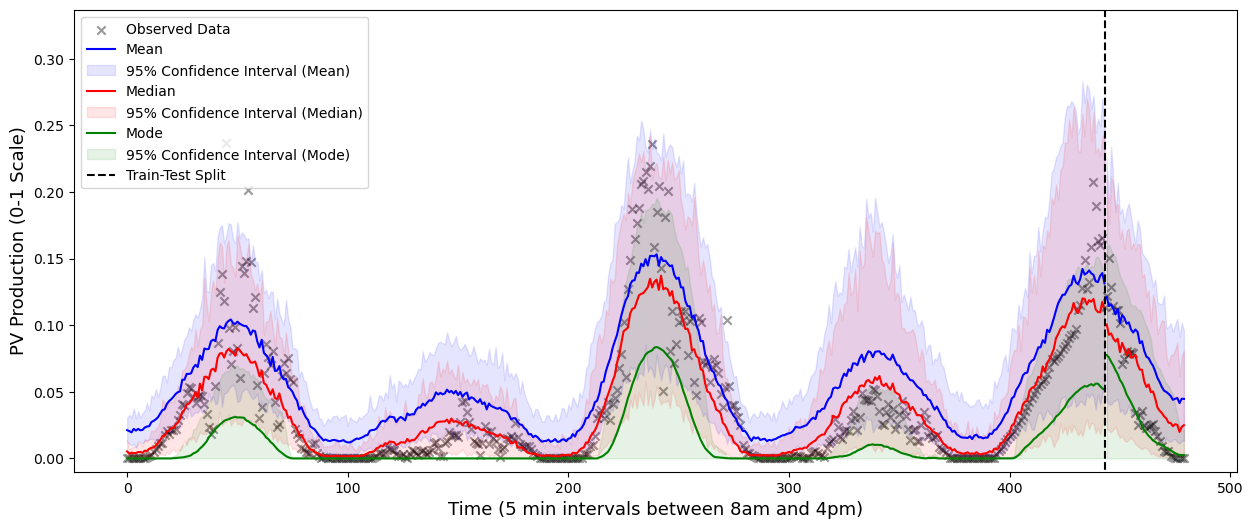

Iter 30/300 - Loss: -2.039
Iter 60/300 - Loss: -2.522
Iter 90/300 - Loss: -2.619
Iter 120/300 - Loss: -2.662
Iter 150/300 - Loss: -2.692
Iter 180/300 - Loss: -2.713
Iter 210/300 - Loss: -2.729
Iter 240/300 - Loss: -2.744
Iter 270/300 - Loss: -2.756
Iter 300/300 - Loss: -2.766


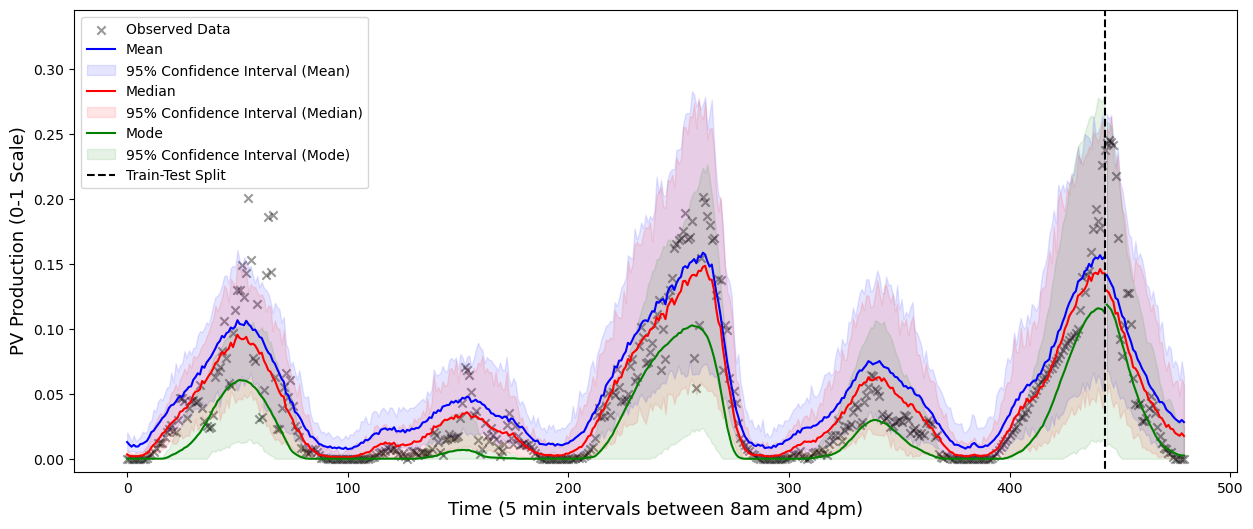

Iter 30/300 - Loss: -0.818
Iter 60/300 - Loss: -1.656
Iter 90/300 - Loss: -2.030
Iter 120/300 - Loss: -2.217
Iter 150/300 - Loss: -2.319
Iter 180/300 - Loss: -2.383
Iter 210/300 - Loss: -2.423
Iter 240/300 - Loss: -2.450
Iter 270/300 - Loss: -2.471
Iter 300/300 - Loss: -2.488


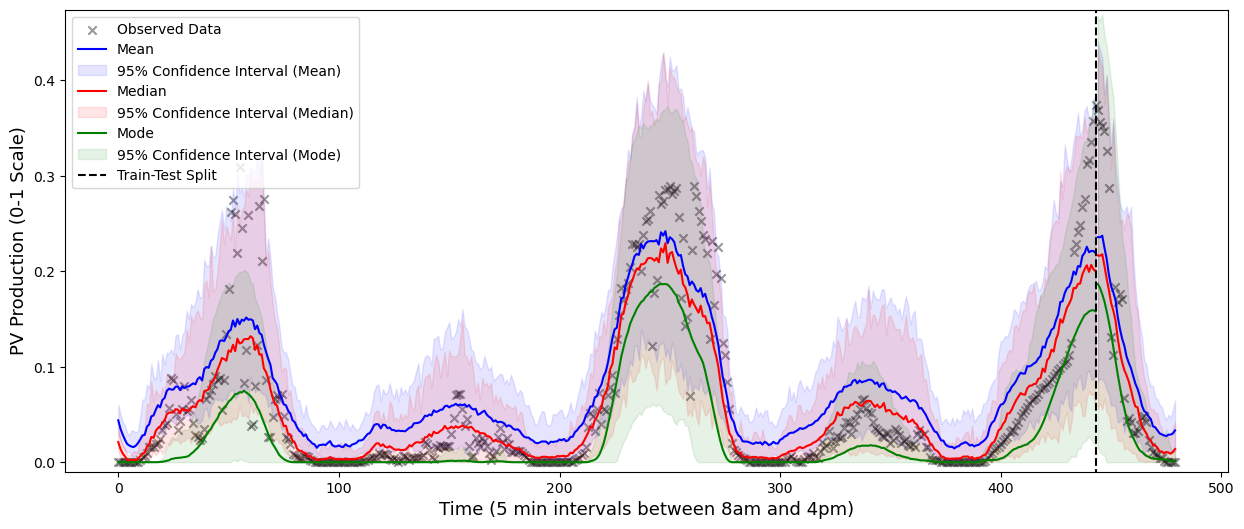

Iter 30/300 - Loss: -0.446
Iter 60/300 - Loss: -1.447
Iter 90/300 - Loss: -1.878
Iter 120/300 - Loss: -2.071
Iter 150/300 - Loss: -2.162
Iter 180/300 - Loss: -2.211
Iter 210/300 - Loss: -2.242
Iter 240/300 - Loss: -2.265
Iter 270/300 - Loss: -2.280
Iter 300/300 - Loss: -2.291


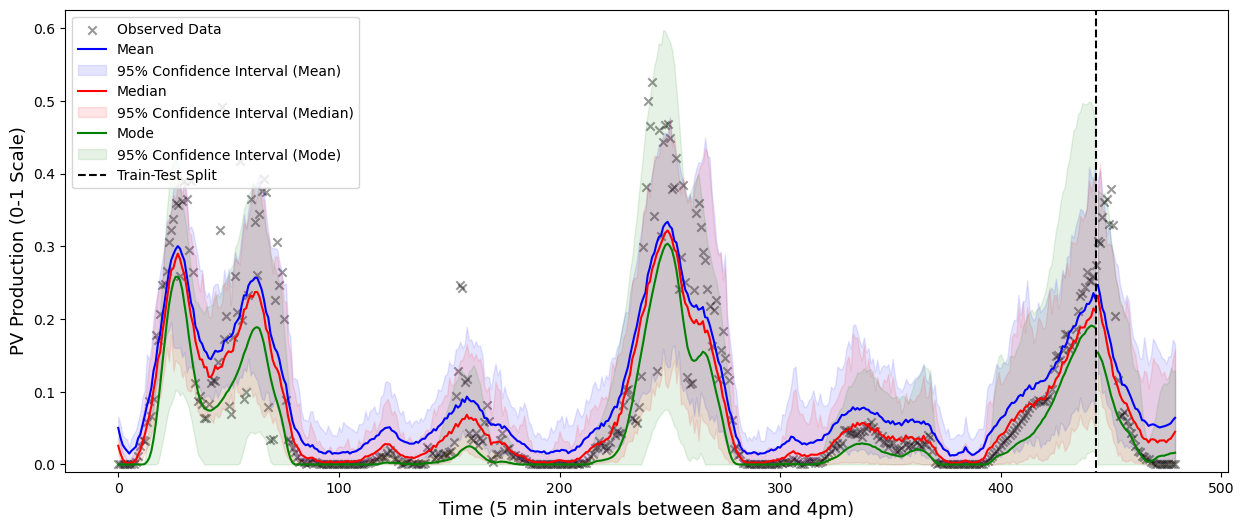

Iter 30/300 - Loss: 0.186
Iter 60/300 - Loss: -1.200
Iter 90/300 - Loss: -1.744
Iter 120/300 - Loss: -2.024
Iter 150/300 - Loss: -2.182
Iter 180/300 - Loss: -2.274
Iter 210/300 - Loss: -2.330
Iter 240/300 - Loss: -2.368
Iter 270/300 - Loss: -2.394
Iter 300/300 - Loss: -2.414


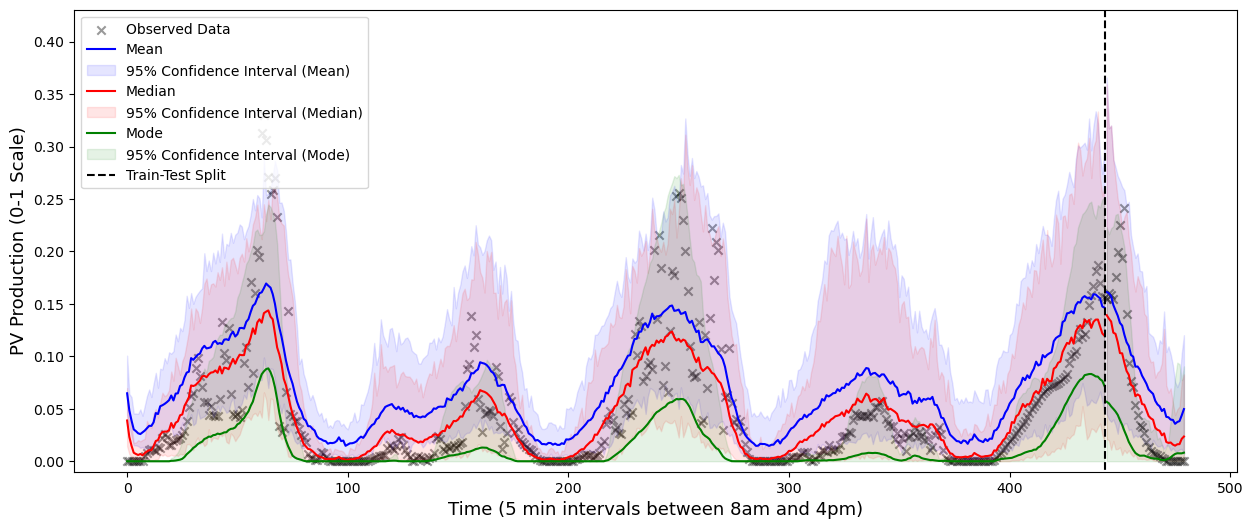

Iter 30/300 - Loss: 0.824
Iter 60/300 - Loss: -0.989
Iter 90/300 - Loss: -1.529
Iter 120/300 - Loss: -1.821
Iter 150/300 - Loss: -2.003
Iter 180/300 - Loss: -2.117
Iter 210/300 - Loss: -2.185
Iter 240/300 - Loss: -2.227
Iter 270/300 - Loss: -2.256
Iter 300/300 - Loss: -2.277


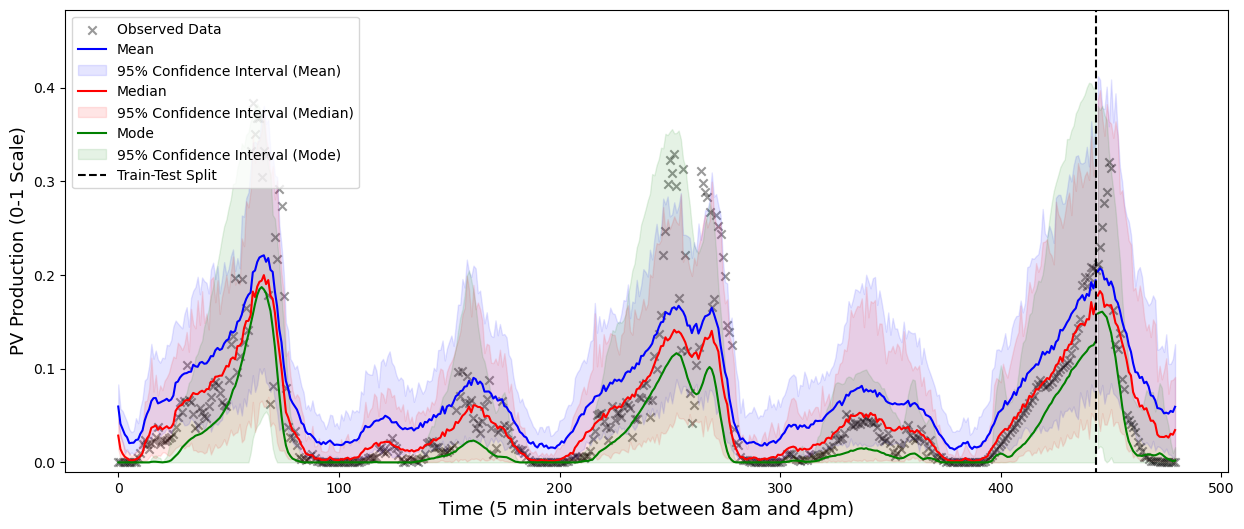

Iter 30/300 - Loss: -0.423
Iter 60/300 - Loss: -1.327
Iter 90/300 - Loss: -1.788
Iter 120/300 - Loss: -2.003
Iter 150/300 - Loss: -2.107
Iter 180/300 - Loss: -2.161
Iter 210/300 - Loss: -2.197
Iter 240/300 - Loss: -2.218
Iter 270/300 - Loss: -2.230
Iter 300/300 - Loss: -2.239


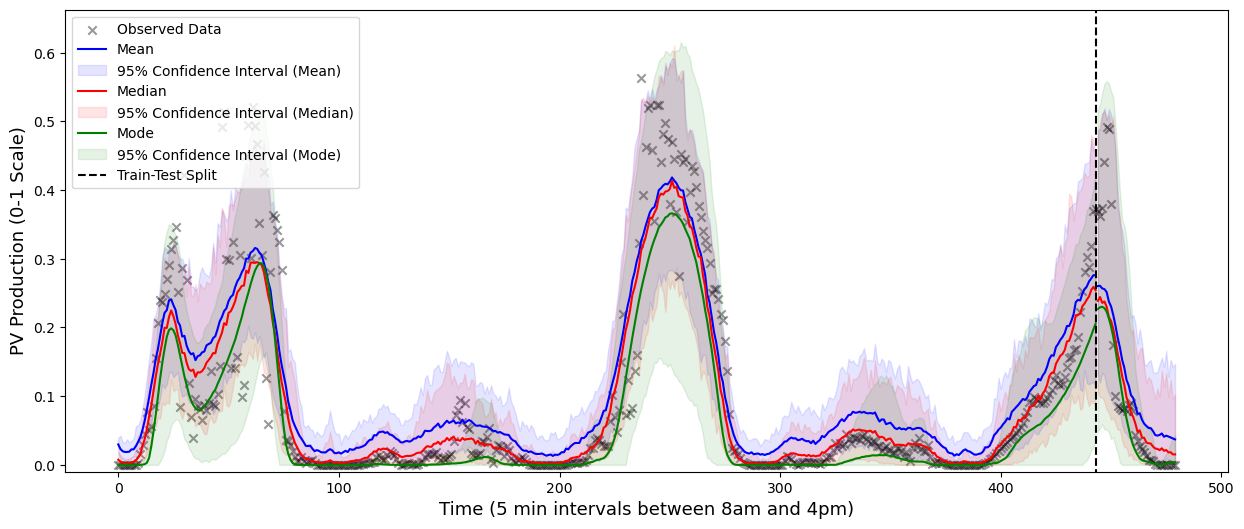

Iter 30/300 - Loss: -0.409
Iter 60/300 - Loss: -1.403
Iter 90/300 - Loss: -1.846
Iter 120/300 - Loss: -2.048
Iter 150/300 - Loss: -2.143
Iter 180/300 - Loss: -2.194
Iter 210/300 - Loss: -2.232
Iter 240/300 - Loss: -2.255
Iter 270/300 - Loss: -2.272
Iter 300/300 - Loss: -2.286


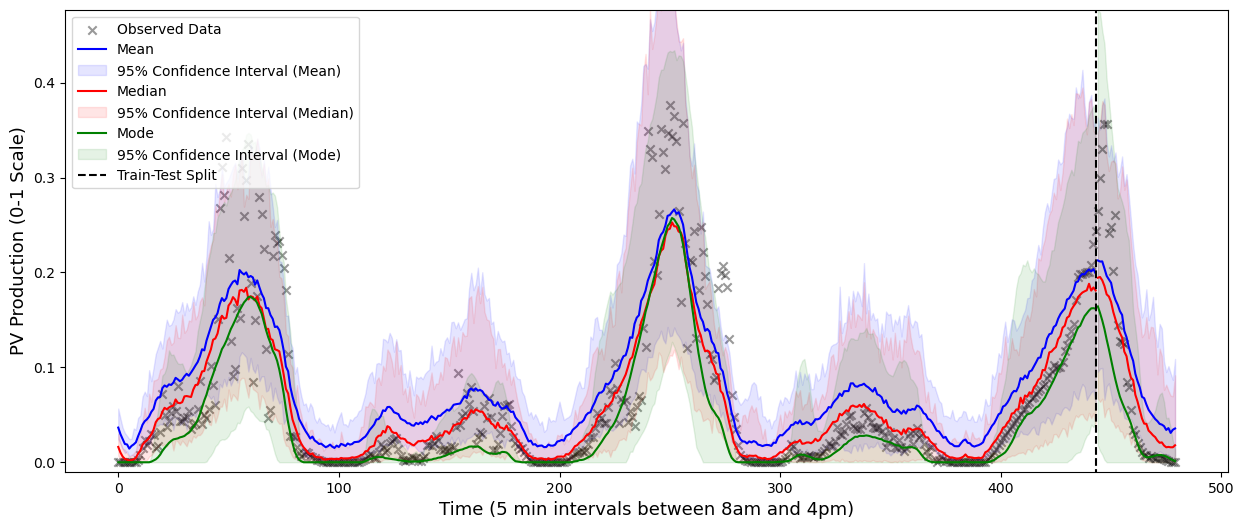

Iter 30/300 - Loss: -1.033
Iter 60/300 - Loss: -1.813
Iter 90/300 - Loss: -2.132
Iter 120/300 - Loss: -2.270
Iter 150/300 - Loss: -2.332
Iter 180/300 - Loss: -2.364
Iter 210/300 - Loss: -2.384
Iter 240/300 - Loss: -2.399
Iter 270/300 - Loss: -2.410
Iter 300/300 - Loss: -2.420


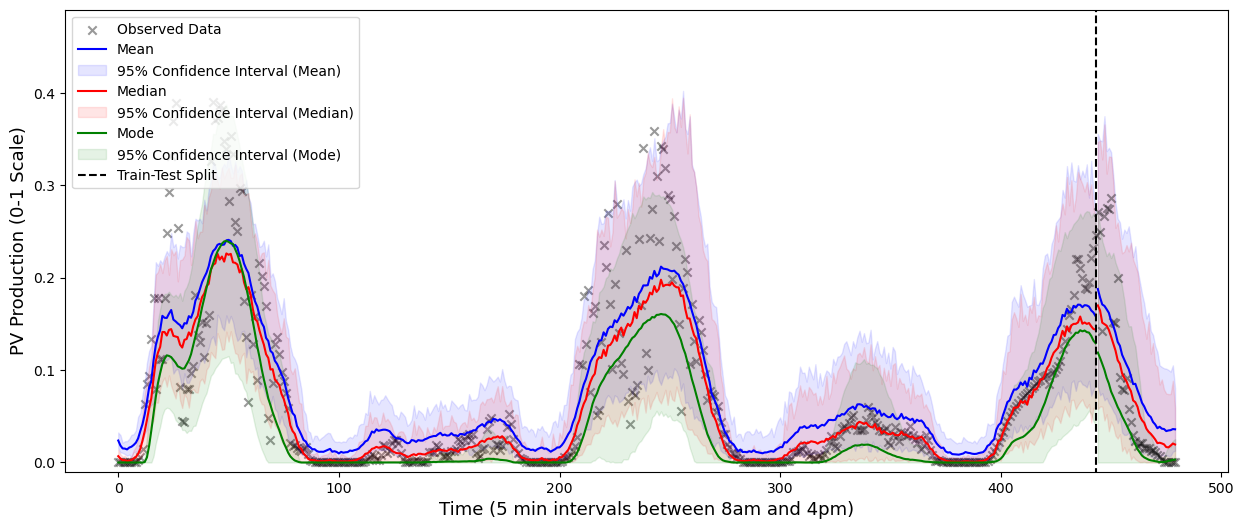

Iter 30/300 - Loss: -0.907
Iter 60/300 - Loss: -1.758
Iter 90/300 - Loss: -2.105
Iter 120/300 - Loss: -2.247
Iter 150/300 - Loss: -2.314
Iter 180/300 - Loss: -2.353
Iter 210/300 - Loss: -2.374
Iter 240/300 - Loss: -2.389
Iter 270/300 - Loss: -2.401
Iter 300/300 - Loss: -2.411


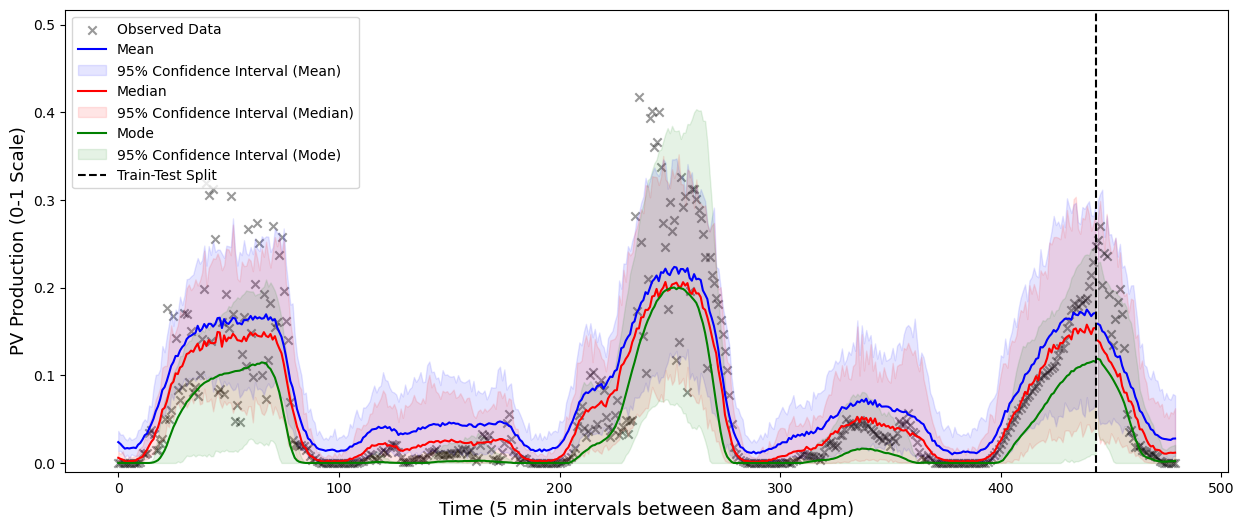

Iter 30/300 - Loss: -1.759
Iter 60/300 - Loss: -2.228
Iter 90/300 - Loss: -2.323
Iter 120/300 - Loss: -2.364
Iter 150/300 - Loss: -2.390
Iter 180/300 - Loss: -2.409
Iter 210/300 - Loss: -2.425
Iter 240/300 - Loss: -2.437
Iter 270/300 - Loss: -2.447
Iter 300/300 - Loss: -2.456


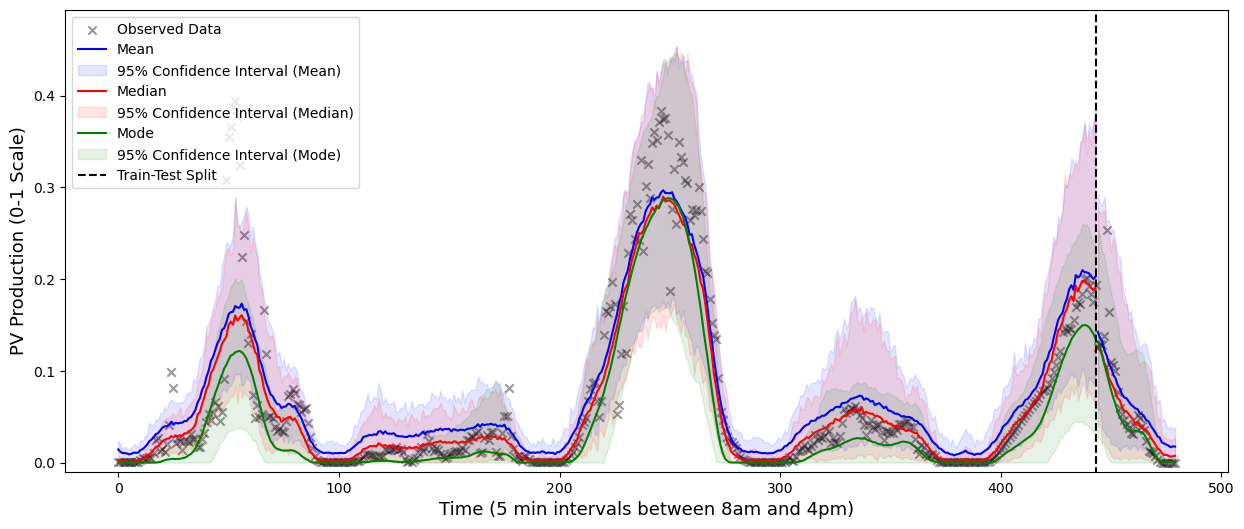

Iter 30/300 - Loss: -1.123
Iter 60/300 - Loss: -2.006
Iter 90/300 - Loss: -2.367
Iter 120/300 - Loss: -2.521
Iter 150/300 - Loss: -2.595
Iter 180/300 - Loss: -2.640
Iter 210/300 - Loss: -2.667
Iter 240/300 - Loss: -2.686
Iter 270/300 - Loss: -2.702
Iter 300/300 - Loss: -2.716


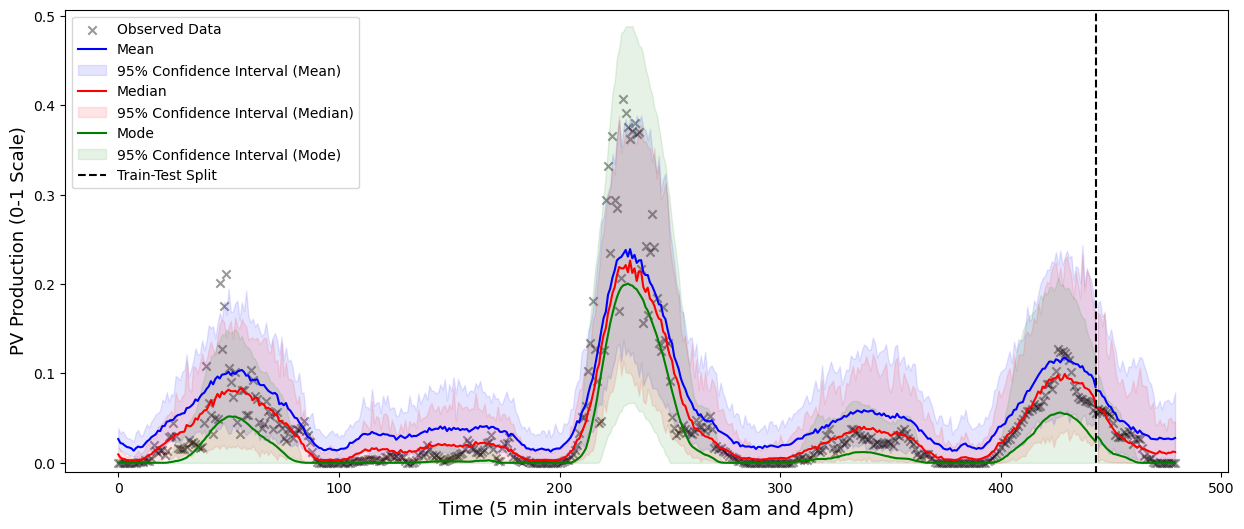

In [319]:
jitter = 1e-4
config = {  'type': 'stochastic',
            'name': 'mean_field',
            'num_inducing_points': x_inducing.size(0),
            'mean_init_std': 2,
            }

for idx in range(y_train.size(1)):
    
  
    inputs_mean = { 'X': x_train, 
                    'y': y_train[:, idx], 
                    'mean_module': gpytorch.means.ZeroMean(),
                    'covar_module': quasi_periodic_matern,
                    'likelihood': BetaLikelihood_MeanParametrization(scale=10,
                                                                     correcting_scale=1,
                                                                     lower_bound=0.10,
                                                                     upper_bound=0.80),
                    'config': config,
                    'jitter': jitter
                }

    model_beta = ApproximateGPBaseModel(**inputs_mean)
    model_beta.fit(n_iter=300, lr=0.1, optim=torch.optim.Adam, device=torch.device('cpu'), verbose=True)    
    
    preds = model_beta.predict(x, device=torch.device('cpu'))
    plot_gp(model_beta, x_train, x_test, y_train[:,idx], y_test[:,idx], y_inducing=y_inducing[:,idx], pred_type='all')


# Hyperparameter Optimization

In [8]:
config = {'type': 'stochastic',
            'name': 'mean_field',
            'num_inducing_points': x_train.size(0),
            'mean_init_std': 1,
            }

jitter = 1e-4

hyper_opt = HyperParameterOptimization( model='beta',
                                        x_train=x_train,
                                        y_train=y_train,
                                        x_test=x_test,
                                        y_test=y_test,
)
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: hyper_opt.objective(trial, config, jitter, kernel='matern'), n_trials=10)

[I 2023-06-28 15:49:26,222] A new study created in memory with name: no-name-bddeaeaf-a966-4f94-ab59-4a13fb380c66
/Users/eirikbaekkelund/opt/anaconda3/envs/gp/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 30] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 26].
  warnings.warn(
[I 2023-06-28 15:52:11,973] Trial 0 finished with value: 0.044488128274679184 and parameters: {'matern_L_shape': 2.0, 'matern_L_rate': 6.0, 'signal_matern_shape': 7.0, 'signal_matern_rate': 9.0, 'likelihood_scale': 16, 'likelihood_correcting_scale': 3.0, 'lr': 0.30000000000000004}. Best is trial 0 with value: 0.044488128274679184.
[I 2023-06-28 15:54:52,988] Trial 1 finished with value: 0.04648548364639282 and parameters: {'matern_L_shape': 1.0, 'matern_L_rate': 3.0, 'signal_matern_shape': 2.0, 'signal_matern_rate': 7.0, 'likelihood_scale': 26, 'likelihood_correcting_scale': 3.0, 'lr': 0.1}. Best is trial 0 with value:

In [8]:
from optuna.visualization import plot_optimization_history, plot_contour, plot_parallel_coordinate, plot_param_importances

In [9]:
plot_optimization_history(study)

In [12]:
plot_contour(study, params=[ 'period_P_shape', 'period__P_rate'])

In [13]:
plot_parallel_coordinate(study)

In [14]:
plot_param_importances(study)

In [15]:
best_params = study.best_params
best_params

{'matern_L_shape': 5.0,
 'matern_L_rate': 4.0,
 'signal_matern_shape': 7.0,
 'signal_matern_rate': 5.0,
 'periodic_L_shape': 5.0,
 'period_L_rate': 2.0,
 'period_P_shape': 5.0,
 'period__P_rate': 2.0,
 'signal_periodic_shape': 9.0,
 'signal_periodic_rate': 1.0,
 'likelihood_scale': 16,
 'likelihood_correcting_scale': 1.0,
 'lr': 0.1}

In [21]:
matern_lengthscale_shape = best_params['matern_L_shape']
matern_lengthscale_rate = best_params['matern_L_rate']
signal_matern_shape = best_params['signal_matern_shape']
signal_matern_rate = best_params['signal_matern_rate']
periodic_lengthscale_shape = best_params['periodic_L_shape']
periodic_lengthscale_rate = best_params['period_L_rate']
periodic_period_shape = best_params['period_P_shape']
periodic_period_rate = best_params['period__P_rate']
signal_periodic_shape = best_params['signal_periodic_shape']
signal_periodic_rate = best_params['signal_periodic_rate']
likelihood_scale = best_params['likelihood_scale']
likelihood_correcting_scale = best_params['likelihood_correcting_scale']
lr = best_params['lr']

matern_base = MaternKernel(nu=3/2,
                        ard_num_dims=x.shape[1],
                        lengthscale_prior=gpytorch.priors.GammaPrior(matern_lengthscale_shape, matern_lengthscale_rate),
                        lengthscale_constraint=gpytorch.constraints.Positive()
                        )
scaled_matern = ScaleKernel(matern_base,
                            outputscale_prior=gpytorch.priors.GammaPrior(signal_matern_shape, signal_matern_rate),
                            outputscale_constraint=gpytorch.constraints.Positive()
                            )
periodic = PeriodicKernel(  period_prior=gpytorch.priors.GammaPrior(periodic_period_shape, periodic_period_rate),
                            period_constraint=gpytorch.constraints.Positive(),
                            lengthscale_prior=gpytorch.priors.GammaPrior(periodic_lengthscale_shape, periodic_lengthscale_rate),
                            lengthscale_constraint=gpytorch.constraints.Positive()
                        )
scaled_periodic = ScaleKernel(periodic,
                                outputscale_prior=gpytorch.priors.GammaPrior(signal_periodic_shape, signal_periodic_rate),
                                outputscale_constraint=gpytorch.constraints.Positive()
                            )
product_kernel = ProductKernel(scaled_periodic, scaled_matern)
add_kernel = AdditiveKernel(product_kernel, scaled_matern)

In [ ]:
jitter = 1e-4

for idx in range(y_train.size(1)):
    
    config = {  'type': 'stochastic',
                'name': 'mean_field',
                'num_inducing_points': x_inducing.size(0),
                'mean_init_std': 1,
                }
    inputs_mean = { 'X': x_train, 
                    'y': y_train[:, idx], 
                    'mean_module': gpytorch.means.ConstantMean(),
                    'covar_module': add_kernel,
                    'likelihood': BetaLikelihood_MeanParametrization(scale=likelihood_scale,
                                                                     correcting_scale=likelihood_correcting_scale,
                                                                     lower_bound=0.10,
                                                                     upper_bound=0.80),
                    'config': config,
                    'jitter': jitter
                }

    model_beta = ApproximateGPBaseModel(**inputs_mean)
    model_beta.fit(n_iter=300, lr=0.1, optim=torch.optim.Adam, device=torch.device('cpu'), verbose=True)    
    
    preds = model_beta.predict(x, device=torch.device('cpu'))
    plot_gp(model=model_beta, 
            x_train=x_train, 
            x_test=x_test, 
            y_train=y_train[:,idx], 
            y_test=y_test[:,idx], 
            y_inducing=y_inducing[:,idx], 
            pred_type='mode')

In [241]:
import gpytorch
import torch
from gpytorch.distributions import MultitaskMultivariateNormal
from gpytorch.models import ApproximateGP
from src.variational_dist import VariationalBase
from gpytorch.variational import (VariationalStrategy, 
                                  LMCVariationalStrategy, 
                                  IndependentMultitaskVariationalStrategy)


class MultiTaskBetaGP(ApproximateGP):
    """ 
    Base model for performing inference with a Multitask Gaussian Process (GP) using
    stochastic variational inference (SVI). The model has several outputs and a 
    Beta likelihood is used for each output to account for bounded data.
    """
    def __init__(self,
                 X : torch.Tensor,
                 y : torch.Tensor,
                 likelihood : gpytorch.likelihoods.Likelihood,
                 mean_module : gpytorch.means.Mean,
                 covar_module : gpytorch.kernels.Kernel,
                 variational_strategy : str,
                 config : dict,
                 num_latents : int,
                 jitter : float = 1e-4,
                 learn_inducing_locations : bool = False
                 ):
        if isinstance(likelihood, gpytorch.likelihoods.BetaLikelihood):
            assert y.min() >= 0 and y.max() <= 1, 'y must be in the range [0, 1] for Beta likelihood'
        
        assert X.size(1) == y.size(0), 'X and y must have same number of data points'
        assert variational_strategy in ['lmc', 'mt_indep'], 'Variational strategy must be either lmc or mt_indep'

        # add perturbation to the data to avoid numerical issues for bounded outputs
        if y.min() == 0:
            y += jitter
        
        if y.max() == 1:
            y -= jitter
        
        self.X = X
        self.y = y
        
        variational_dist = VariationalBase(config).variational_distribution
        
        base_variational = VariationalStrategy( self,
                                                inducing_points=X,
                                                variational_distribution=variational_dist,
                                                learn_inducing_locations=learn_inducing_locations,
                                                jitter_val=jitter)

        if variational_strategy == 'lmc':
            variational_strategy = LMCVariationalStrategy(base_variational_strategy=base_variational,
                                                          num_tasks=y.size(1),
                                                          num_latents=num_latents,
                                                          latent_dim=-1,
                                                          jitter_val=jitter)
        
        elif variational_strategy == 'mt_indep':
            variational_strategy = IndependentMultitaskVariationalStrategy(base_variational_strategy=base_variational,
                                                                           num_tasks=y.size(1),
                                                                           )

        super().__init__(variational_strategy)

        self.mean_module = mean_module
        self.covar_module = covar_module
        self.likelihood = likelihood
    
    def forward(self, x, **kwargs):
        """ 
        Forward pass through the model
        """
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    def predict(self, X, device : torch.device):
        """ 
        Make predictions with the model
        """
        self.to(device)
        
        self.eval()
        self.likelihood.eval()

        if not isinstance(self.likelihood, gpytorch.likelihoods.GaussianLikelihood):
                with gpytorch.settings.num_likelihood_samples(30):
                    # TODO if beta likelihood then predict using the mode
                    # the mode should give the most likely value for the prediction
                    preds = self.likelihood(self(X)) 
        else:
            preds = self.likelihood(self(X))
        
        return preds

    def get_inducing_points(self):
        """ 
        Get inducing points
        """
        return self.variational_strategy.inducing_points
    
    def fit(self,
            n_iter : int,
            lr : float,
            optim : torch.optim.Optimizer,
            device : torch.device,
            verbose : bool = True
            ):
        """
        Fit the model using SVI
        """
        self.to(device)
        
        self.train()
        self.likelihood.train()

        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        
        elbo = gpytorch.mlls.VariationalELBO(self.likelihood, self, num_data=self.y.size(0))

        print_freq = n_iter // 10
        self.losses = []

        for i in range(n_iter):
            optimizer.zero_grad()
            output = self(self.X)
            loss = -elbo(output, self.y).sum()
            loss.backward()
            optimizer.step()

            self.losses.append(loss.item())

            if verbose and (i+1) % print_freq == 0:
                print(f'Iter: {i+1}/{n_iter} - Loss: {loss.item():.3f}')


In [327]:
matern_base = MaternKernel(nu=3/2, 
                      ard_num_dims=x.shape[1], 
                      lengthscale_prior=gpytorch.priors.GammaPrior(2, 8),
                      lengthscale_constraint=gpytorch.constraints.Positive(),
                      batch_shape=torch.Size([y_train.size(1)])
                      )
periodic = PeriodicKernel(period_length_prior=gpytorch.priors.GammaPrior(3, 2),
                            period_length_constraint=gpytorch.constraints.Positive(),
                            batch_shape=torch.Size([y_train.size(1)])
                        )
scaled_periodic = ScaleKernel(periodic,
                                outputscale_prior=gpytorch.priors.GammaPrior(5, 1),
                                outputscale_constraint=gpytorch.constraints.Positive(),
                                batch_shape=torch.Size([y_train.size(1)])
                            )
scaled_matern = ScaleKernel(matern_base, 
                            outputscale_prior=gpytorch.priors.GammaPrior(5, 2),
                            outputscale_constraint=gpytorch.constraints.Interval(0.1, 1),
                            batch_shape=torch.Size([y_train.size(1)])
                            )
product_kernel_matern_periodic = ScaleKernel(periodic * matern_base,
                             outputscale_prior = gpytorch.priors.GammaPrior(5, 2),
                             outputscale_constraint=gpytorch.constraints.Positive(),
                                batch_shape=torch.Size([y_train.size(1)])
                            )
rbf_kernel = ScaleKernel(RBFKernel())
product_kernel_rbf_matern = ScaleKernel(rbf_kernel * scaled_matern, batch_shape=torch.Size([y_train.size(1)]))


quasi_periodic_rbf = AdditiveKernel(product_kernel_rbf_matern, scaled_matern)
quasi_periodic_matern = AdditiveKernel(product_kernel_matern_periodic, scaled_matern)

In [328]:
num_latents = 5
matern_base = MaternKernel(nu=3/2, 
                      ard_num_dims=x.shape[1], 
                      lengthscale_prior=gpytorch.priors.GammaPrior(2, 8),
                      lengthscale_constraint=gpytorch.constraints.Positive(),
                      batch_shape=torch.Size([num_latents])
                      )

scaled_matern = ScaleKernel(matern_base, 
                            outputscale_prior=gpytorch.priors.GammaPrior(5, 2),
                            outputscale_constraint=gpytorch.constraints.Interval(0.1, 1),
                            batch_shape=torch.Size([num_latents])
                            )

rbf = ScaleKernel(RBFKernel(), batch_shape=torch.Size([num_latents]))

In [329]:
# get individual time series
y_in = y[:, :num_latents]

if y_in.max() > 1:
    y_in[y_in > 1] = 1
# get time related variables
periodic_time = dl.periodic_mapping(time, DAY_MIN, DAY_MAX, MINUTE_INTERVAL)
x = torch.stack([time, periodic_time], dim=1)

# standardize time dimension of x
x[:, 0] = (x[:, 0] - x[:, 0].mean()) / x[:, 0].std()

# split into train and test
x_train, y_train, x_test, y_test = dl.train_test_split(x, y_in, n_hours=N_HOURS_PRED)
print(x_train.shape, y_train.shape)


torch.Size([444, 2]) torch.Size([444, 5])


In [330]:
# make inducing points to have shape (2 x num_data_points, 1)
x_inducing = x_train.repeat(num_latents, 1, 1).reshape(num_latents, -1, 2)
y_inducing = y_train
print(x_inducing.shape, y_inducing.shape)

torch.Size([5, 444, 2]) torch.Size([444, 5])


In [333]:
jitter = 1e-3
config = {
            'type': 'stochastic',
            'name': 'mean_field',
            'num_inducing_points': x_inducing.size(-2),
            'batch_shape': torch.Size([num_latents]),
}

multitask_model = MultiTaskBetaGP(X=x_inducing,
                                    y=y_train,
                                    likelihood=BetaLikelihood_MeanParametrization(scale=15,
                                                                                    correcting_scale=1,
                                                                                    lower_bound=0.10,
                                                                                    upper_bound=0.80),
                                    mean_module=gpytorch.means.ZeroMean(batch_shape=torch.Size([num_latents])),
                                    covar_module=quasi_periodic_matern,
                                    config=config,
                                    variational_strategy='lmc',
                                    num_latents=num_latents,
                                    jitter=jitter,
                                    learn_inducing_locations=False
                                )

In [334]:
multitask_model.fit(n_iter=300, lr=0.4, optim=torch.optim.Adam, device=torch.device('cpu'), verbose=True)

Iter: 30/300 - Loss: 55.945
Iter: 60/300 - Loss: 14.816
Iter: 90/300 - Loss: 11.905
Iter: 120/300 - Loss: 8.434
Iter: 150/300 - Loss: -2.229
Iter: 180/300 - Loss: -2.473
Iter: 210/300 - Loss: -2.528
Iter: 240/300 - Loss: -2.534
Iter: 270/300 - Loss: -2.538
Iter: 300/300 - Loss: -2.541


In [335]:
def mode_beta_dist(alpha, beta):
    """ 
    Calculate the mode of a beta distribution given the alpha and beta parameters

    Args:
        alpha (torch.Tensor): alpha parameter
        beta (torch.Tensor): beta parameter
    
    Returns:
        mode (torch.Tensor): mode of the beta distribution
    """
    result = np.zeros_like(alpha)  # Initialize an array of zeros with the same shape as alpha

    mask_alpha_gt_1 = alpha > 1
    mask_beta_gt_1 = beta > 1
    mask_alpha_eq_beta = alpha == beta
    mask_alpha_le_1 = alpha <= 1
    mask_beta_le_1 = beta <= 1

    result[mask_alpha_gt_1 & mask_beta_gt_1] = (alpha[mask_alpha_gt_1 & mask_beta_gt_1] - 1) / (alpha[mask_alpha_gt_1 & mask_beta_gt_1] + beta[mask_alpha_gt_1 & mask_beta_gt_1] - 2)
    result[mask_alpha_eq_beta] = 0.5
    result[mask_alpha_le_1 & mask_beta_gt_1] = 0
    result[mask_alpha_gt_1 & mask_beta_le_1] = 1

    return result

In [336]:
def get_mode_and_quantiles(model, x, quantiles=[0.05, 0.95]):
    
    assert isinstance(model.likelihood, gpytorch.likelihoods.BetaLikelihood), 'Likelihood must be Beta'
    preds_dist = model.predict(x, device=torch.device('cpu'))
    alphas_train = model.likelihood.alpha.detach().cpu().numpy()
    betas_train = model.likelihood.beta.detach().cpu().numpy()

    modes = mode_beta_dist(alphas_train, betas_train)
    mode = modes.mean(axis=0)
    lower, upper = np.quantile(modes, q=quantiles, axis=0)

    return mode, lower, upper

IndexError: index 5 is out of bounds for dimension 1 with size 5

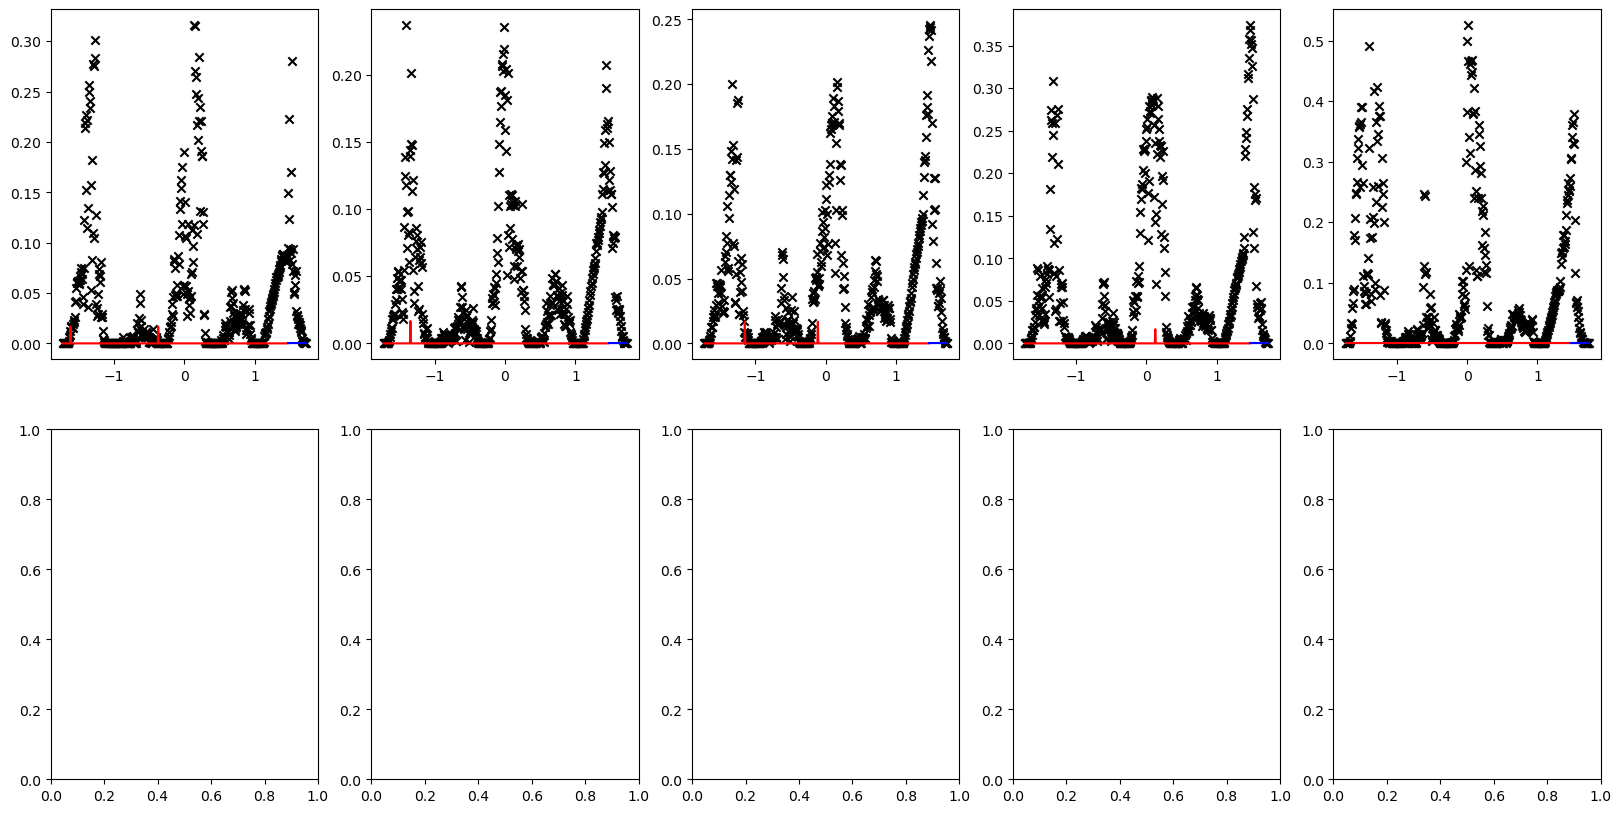

In [337]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))
mode_train, lower_train, upper_train = get_mode_and_quantiles(multitask_model, x_train, quantiles=[0.05, 0.95])
mode_test, lower_test, upper_test = get_mode_and_quantiles(multitask_model, x_test, quantiles=[0.05, 0.95])

for i in range(2):
    for j in range(5):
        idx = 5 * i + j
        ax[i, j].scatter(x[:, 0].numpy(), y_in[:, idx].numpy(), marker='x', label='data', color='black')
        ax[i, j].plot(x_train[:, 0].numpy(), mode_train[:, idx], label='mode', color='red')
        ax[i, j].fill_between(x_train[:, 0].numpy(), lower_train[:, idx], upper_train[:, idx], alpha=0.2, color='red')
        ax[i, j].plot(x_test[:, 0].numpy(), mode_test[:, idx], label='mode', color='blue')
        ax[i, j].fill_between(x_test[:, 0].numpy(), lower_test[:, idx], upper_test[:, idx], alpha=0.2, color='blue')
plt.show()